<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> | Assessment of damage associated with Russia's invasion of Ukraine in 2022</b></p>
</div>

In [1]:
# Download all libraries needed for this project

%matplotlib inline 
import pandas as pd
import numpy as np
import folium as F
import json
import requests
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image
from io import BytesIO
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from math import log10, floor

# print('Matplotlib version: ', mpl.__version__)
# print(plt.style.available)
mpl.style.use(['ggplot'])

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> 1. Data Gathering</b></p>
</div>

Read the CSV files into a Pandas DataFrame

In [2]:
russian_personnel = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_personnel.csv')
russian_equipment = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment.csv')

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> 2. Data Wrangling</b></p>
</div>

### Let's start by getting a basic understanding of the DataFrame and clean the data

In [3]:
russian_personnel

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0.0
1,2022-02-26,3,4300,about,0.0
2,2022-02-27,4,4500,about,0.0
3,2022-02-28,5,5300,about,0.0
4,2022-03-01,6,5710,about,200.0
...,...,...,...,...,...
684,2024-01-10,686,366790,about,NaN
685,2024-01-11,687,367620,about,NaN
686,2024-01-12,688,368460,about,NaN
687,2024-01-13,689,369160,about,NaN


In [4]:
#remove confusing columns and set index for sorting by date.
russian_personnel.drop(['personnel', 'personnel*'], axis=1, inplace=True)
russian_personnel.set_index('date', inplace=True)

# fill empty rows with 0 and change data type
russian_personnel.fillna(0, inplace=True)
russian_personnel = russian_personnel.astype(int)

# replace blanks at the end of POW column with continuous count
last = 0
newpow = []
for i in russian_personnel['POW'].values:
    if last <= i:
        last = i
    elif last > i:
        i = last
    newpow.append(i)
russian_personnel['POW'] = newpow

# view data
russian_personnel.info()
russian_personnel

<class 'pandas.core.frame.DataFrame'>
Index: 689 entries, 2022-02-25 to 2024-01-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   day     689 non-null    int64
 1   POW     689 non-null    int64
dtypes: int64(2)
memory usage: 16.1+ KB


,day,POW
date,,
2022-02-25,2,0
2022-02-26,3,0
2022-02-27,4,0
2022-02-28,5,0
2022-03-01,6,200
...,...,...
2024-01-10,686,496
2024-01-11,687,496
2024-01-12,688,496


In [5]:
russian_equipment

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles,submarines
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,2024-01-10,686,329,324,6038,11216,8684,956,NaN,NaN,6834,23,639,1336.0,NaN,NaN,11575.0,1805.0,1.0
685,2024-01-11,687,329,324,6050,11238,8699,957,NaN,NaN,6834,23,641,1337.0,NaN,NaN,11596.0,1806.0,1.0
686,2024-01-12,688,329,324,6060,11254,8710,957,NaN,NaN,6836,23,642,1339.0,NaN,NaN,11612.0,1806.0,1.0
687,2024-01-13,689,329,324,6065,11269,8728,957,NaN,NaN,6848,23,646,1345.0,NaN,NaN,11632.0,1806.0,1.0


In [6]:
# Check to see if there are blank cells in the data
russian_equipment.isnull()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles,submarines
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False
685,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False
686,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False
687,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False


In [7]:
#fill empty spaces in Dataframe with zeroes and set index for sorting by date.
russian_equipment.fillna(0, inplace=True)
russian_equipment.set_index('date', inplace=True)
russian_equipment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 689 entries, 2022-02-25 to 2024-01-14
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   day                        689 non-null    int64  
 1   aircraft                   689 non-null    int64  
 2   helicopter                 689 non-null    int64  
 3   tank                       689 non-null    int64  
 4   APC                        689 non-null    int64  
 5   field artillery            689 non-null    int64  
 6   MRL                        689 non-null    int64  
 7   military auto              689 non-null    float64
 8   fuel tank                  689 non-null    float64
 9   drone                      689 non-null    int64  
 10  naval ship                 689 non-null    int64  
 11  anti-aircraft warfare      689 non-null    int64  
 12  special equipment          689 non-null    float64
 13  mobile SRBM system         689 non-null

In [8]:
#Consolidating repetitive columns and deleting blank ones
russian_equipment['vehicles and fuel tanks'] += russian_equipment['fuel tank']
russian_equipment['special equipment'] += russian_equipment['military auto']

russian_equipment.drop(columns={'mobile SRBM system', 'fuel tank', 'military auto', 'greatest losses direction'}, inplace=True)

#Change all remaining numeric data to type int
russian_equipment = russian_equipment.astype(int)
russian_equipment.info()
russian_equipment

<class 'pandas.core.frame.DataFrame'>
Index: 689 entries, 2022-02-25 to 2024-01-14
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   day                      689 non-null    int64
 1   aircraft                 689 non-null    int64
 2   helicopter               689 non-null    int64
 3   tank                     689 non-null    int64
 4   APC                      689 non-null    int64
 5   field artillery          689 non-null    int64
 6   MRL                      689 non-null    int64
 7   drone                    689 non-null    int64
 8   naval ship               689 non-null    int64
 9   anti-aircraft warfare    689 non-null    int64
 10  special equipment        689 non-null    int64
 11  vehicles and fuel tanks  689 non-null    int64
 12  cruise missiles          689 non-null    int64
 13  submarines               689 non-null    int64
dtypes: int64(14)
memory usage: 80.7+ KB


,day,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,submarines
date,,,,,,,,,,,,,,
2022-02-25,2,10,7,80,516,49,4,0,2,0,100,60,0,0
2022-02-26,3,27,26,146,706,49,4,2,2,0,130,60,0,0
2022-02-27,4,27,26,150,706,50,4,2,2,0,130,60,0,0
2022-02-28,5,29,29,150,816,74,21,3,2,5,291,60,0,0
2022-03-01,6,29,29,198,846,77,24,3,2,7,305,60,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10,686,329,324,6038,11216,8684,956,6834,23,639,1336,11575,1805,1
2024-01-11,687,329,324,6050,11238,8699,957,6834,23,641,1337,11596,1806,1
2024-01-12,688,329,324,6060,11254,8710,957,6836,23,642,1339,11612,1806,1


In [9]:
#categorizing equipment based on type.
air_units = ['drone','aircraft','helicopter', 'cruise missiles']
water_units = ['naval ship', 'submarines']
ground_units = ['APC','vehicles and fuel tanks', 'tank', 'field artillery', 'MRL',  'anti-aircraft warfare', 'special equipment']

## Acronyms
* POW -  Prisoner of War
* MRL -  Multiple Rocket Launcher
* APC -  Armored Personnel Carrier
* SRBM - Short-range ballistic missile
* UAV -  Unmanned Aerial Vehicle
* RPA -  Remotely Piloted Vehicle

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> 3. Exploratory Data Analysis and Visualization</b></p>
</div>

## Problem 1
##### Visually represent the country being invaded.

In [10]:
# Define the coordinates for Ukraine and create the map
ukraine_lat = 48.383022
ukraine_long = 31.1828699
ukraine_map = F.Map(location=[ukraine_lat, ukraine_long], 
                    tiles="cartodbpositron", zoom_start=6.49)

# Create a feature group for Kiev
kiev = F.FeatureGroup()

kiev_lat = 50.4500336
kiev_long = 30.5241361
kiev.add_child(F.CircleMarker([kiev_lat, kiev_long], radius=5, color="red", fill_color="blue"))
ukraine_map.add_child(kiev)

F.Marker([kiev_lat, kiev_long], popup="Ukraine's Capital City").add_to(ukraine_map)

# Read GeoJSON data for Ukraine from file
with open('/kaggle/input/world-countries/world-countries.json', 'r') as geojson_file:
    ukraine_geojson = json.load(geojson_file)

# Add the GeoJSON data to the map
F.GeoJson(ukraine_geojson, name='ukraine', style_function=
          lambda x: {"fillColor": "yellow", "color": "blue"}).add_to(ukraine_map)

print('Navigable Map')
ukraine_map

Navigable Map


## Problem 2
##### Show the total Prisoners of War per day recorded in the Personel table.


In [11]:
# Refine data to extract on the columns needed for this table
pow_data = russian_personnel[["day", "POW"]]

# create figure
fig=go.Figure()

fig.add_trace(go.Scatter(x=pow_data.index, y=pow_data['POW']))

# set title
fig.update_layout(title={'text':'Total Prisoners of War Held to Date',
                         'y':0.93,'x':0.5,'xanchor':'center','yanchor':'top'})

# Add range slider for customized search results
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="todate"),
                dict(count=7, label="1wk", step="day", stepmode="todate"),
                dict(count=30, label="1mth", step="month",stepmode="todate"),
                dict(step="all")]), 
            bgcolor='blue'),
        rangeslider=dict(
            visible=True),
        type="date"))

fig.update_layout(plot_bgcolor='#333')
fig.show()

## Problem 3
##### What is the daily change in POW and compared to Total POW?

In [12]:
# Helper Variables
last = 0
increase = []

# Calculate daily change in POW
for i in (pow_data['POW'].values):
    count = i - last
    increase.append(count)
    last = i
    
# Assign new values to table    
pow_data['Daily Increase in Prisoners of War'] = increase

# Style table
pow_data_ = pow_data[['day', 'POW', 'Daily Increase in Prisoners of War']].set_index('day')
pow_data_.rename(columns={'POW':'Daily Total Prisoners of War'}, inplace=True)

pow_data_

,Daily Total Prisoners of War,Daily Increase in Prisoners of War
day,,
2,0,0
3,0,0
4,0,0
5,0,0
6,200,200
...,...,...
686,496,0
687,496,0
688,496,0


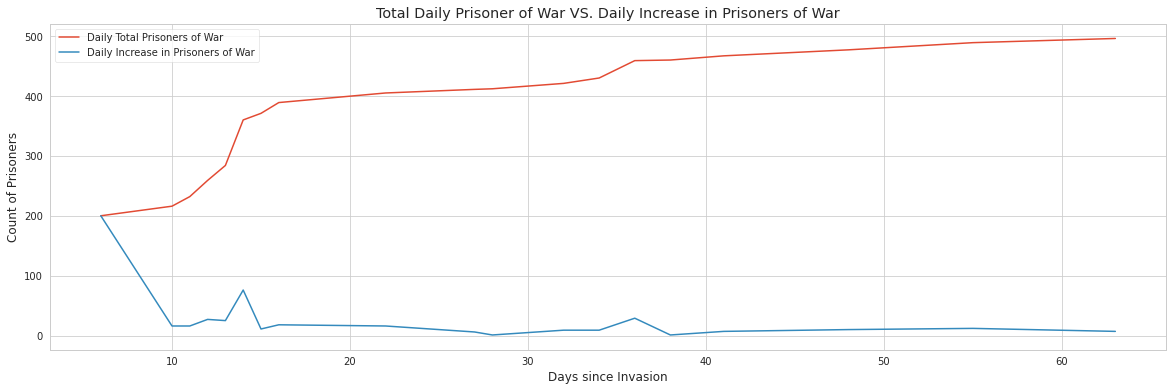

In [13]:
# Set graph style
sns.set_style('whitegrid')

# Create graph
pow_data_[pow_data_['Daily Increase in Prisoners of War'] > 0].plot(figsize=(20,6))
plt.xlabel('Days since Invasion')
plt.ylabel('Count of Prisoners')
plt.title("Total Daily Prisoner of War VS. Daily Increase in Prisoners of War")
plt.show()

## Problem 4
##### Visualize the daily change in POW.

count     19.000000
mean      26.105263
std       45.201886
min        1.000000
25%        8.000000
50%       12.000000
75%       21.500000
max      200.000000
Name: Daily Increase in Prisoners of War, dtype: float64


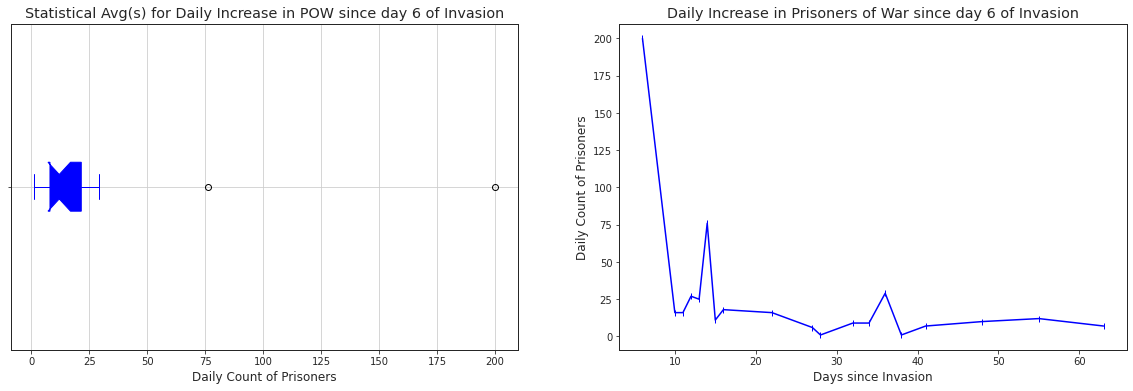

In [14]:
sns.set_style('ticks')

# Create Plot Object
fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Assessing data after day 10 when POW is within a more narrow/normalized range. See above graph
plot_data1=pow_data_['Daily Increase in Prisoners of War'][pow_data_['Daily Increase in Prisoners of War'] > 0]
print(plot_data1.describe())

# Subplot 1: Box plot
plot_data1.plot(kind='box', color='blue', figsize=(20, 6), vert=False, ax=ax0, notch=True, label="", 
                grid=True, patch_artist=True) 
ax0.set_title(f'Statistical Avg(s) for Daily Increase in POW since day {plot_data1.index[0]} of Invasion')
ax0.set_xlabel('Daily Count of Prisoners')

# Subplot 2: Line plot
plot_data1.plot(color='blue', figsize=(20,6), ax=ax1, marker="|")
ax1.set_xlabel('Days since Invasion')
ax1.set_ylabel('Daily Count of Prisoners')
ax1.set_title(f"Daily Increase in Prisoners of War since day {plot_data1.index[0]} of Invasion")

# Print graph
plt.show()

In [15]:
print(f'There are approximately {round(plot_data1.describe()[1])} daily prisoners of war on average.')

There are approximately 26 daily prisoners of war on average.


## Problem 5
##### What Is the total daily loss for all equipment?

In [16]:
# Structure data from dataset
daily_total_equip_loss = russian_equipment.reset_index('date')
daily_total_equip_loss.drop(columns={'date'}, inplace=True)
daily_total_equip_loss.set_index('day', inplace=True)

# Create new dataframe for graph object
daily_total_equip_loss['Daily Total Equipment Loss'] = pd.DataFrame(daily_total_equip_loss.sum(axis=1))
daily_total_equip_loss[['Daily Total Equipment Loss']]

,Daily Total Equipment Loss
day,
2,828
3,1152
4,1157
5,1480
6,1580
...,...
686,49760
687,49835
688,49893


In [17]:
# Create and show graph
plot_data2 = daily_total_equip_loss[['Daily Total Equipment Loss']]

fig=px.scatter(plot_data2, x=plot_data2.index, y='Daily Total Equipment Loss', marginal_x='box', 
               color='Daily Total Equipment Loss')

fig.update_layout(plot_bgcolor='rgba(0,5,5,0)',
                  title={'text':'Total Equipment Lost Per Day','y':0.93,'x':0.45,'xanchor':'center','yanchor':'top'})

fig.show()

## Problem 6
##### Create a word map visual to show the equipment types with the highest percentage loss in total equipment loss.

In [18]:
sns.set_style('white')
# Get the most recent loss data
total = int(daily_total_equip_loss.iloc[-1: , -1:].values)

# gather data pertaining to the total equipment lost and generate a count of the equipment lost by type
total_loss = daily_total_equip_loss.iloc[-1: , :-1]
total_loss.reset_index(inplace=True)
total_loss = pd.DataFrame(total_loss.drop('day', axis=1).transpose()).reset_index()
total_loss.rename(columns={'index':'Equipment', 0:'Count'}, inplace=True)
total_loss.set_index('Equipment', inplace=True)
total_loss.sort_values(by='Count', inplace=True)

total_loss

,Count
Equipment,
submarines,1
naval ship,23
helicopter,324
aircraft,329
anti-aircraft warfare,648
MRL,957
special equipment,1353
cruise missiles,1814
tank,6075


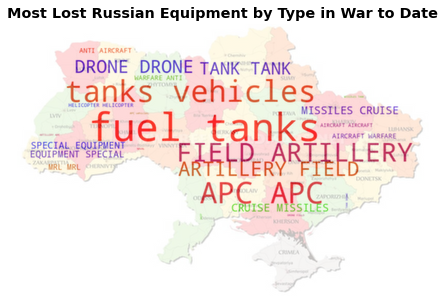

In [19]:
# duplicate equipment name based on how much they contribute to total loss in the shape of the Ukraine map
word_string=""
max_words = total_loss.mean()
for equipment in total_loss.index:
     times_repeat = int(total_loss.loc[equipment, 'Count']/total * max_words)
     word_string = word_string.upper() + ((equipment + " ") * times_repeat)

# create image of Ukraine map
response = requests.get("https://www.freeworldmaps.net/europe/ukraine/map-ukraine.jpg")
ukraine_mask = np.array(Image.open(BytesIO(response.content)))

# create word cloud
word_cloud = WordCloud(background_color = 'white', colormap='brg', mask=ukraine_mask).generate(word_string)

# Display cloud
plt.figure(figsize=(13,5))
plt.imshow(word_cloud, interpolation='bessel')
plt.imshow(ukraine_mask, cmap=plt.cm.gray, interpolation='bessel', alpha=0.3)
plt.title('Most Lost Russian Equipment by Type in War to Date', fontweight='bold', color='black')
plt.axis('off')

plt.show()

## Problem 7
##### How much equipment did Russia lose in the first 5 days of the invasion?

In [20]:
# Getting count of total looses as of day 5
dt5 = daily_total_equip_loss.head(4).drop('Daily Total Equipment Loss', axis=1)

# Create pie chart chowing loss ratio
dict_rl_sum = dt5.sum(axis=0)[1:]
fig = go.Figure(data=[go.Pie(labels=dict_rl_sum.keys()
                             , values=dict_rl_sum.values
                             , textinfo='label'
                             , insidetextorientation='auto'
                )])
chart_title = ('Cumulative Equipment Lost in the First 5 Days: ' + russian_equipment.index[0] + " To " + russian_equipment.index[3])
fig.update_layout(title={'text':chart_title,'y':0.85,'x':0.5,'xanchor':'center','yanchor':'top'})
fig.show()
daily_total_equip_loss.head(4)

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,submarines,Daily Total Equipment Loss
day,,,,,,,,,,,,,,
2,10,7,80,516,49,4,0,2,0,100,60,0,0,828
3,27,26,146,706,49,4,2,2,0,130,60,0,0,1152
4,27,26,150,706,50,4,2,2,0,130,60,0,0,1157
5,29,29,150,816,74,21,3,2,5,291,60,0,0,1480


## Problem 8
##### What is the most recent count of Russian equipment loss?

In [21]:
#Preparing data for charts
def impute_unit(unit_name):
    if unit_name in air_units:
        return "Air Units"
    elif unit_name in water_units:
        return "Water Units"
    else:
        return "Ground Units"

new_df = russian_equipment.tail(1).transpose().reset_index()
new_df.columns = ['equipment_name', 'unit_amount']
new_df = new_df.drop([0], axis=0)

# performing data manipulation, imputing categorized unit type into a new column
new_df['unit_type'] = new_df['equipment_name'].apply(lambda x: impute_unit(x))

# Creating Sunburst chart based on air, ground or naval unit type
fig = px.sunburst(
    new_df, path=['unit_type', 'equipment_name', 'unit_amount'], values='unit_amount',
                  color='unit_type', color_continuous_scale='RdBu'
                  ,title='Total Equipment Loss As At: ' + russian_equipment.index[-1] + ' (Most Recent Data)'
                )
fig.update_layout(title={'y':.9,'x':0.5,'xanchor':'center','yanchor':'top'})
fig.show()
new_df.sort_values(by='unit_amount').set_index(keys='unit_type')

,equipment_name,unit_amount
unit_type,,
Water Units,submarines,1
Water Units,naval ship,23
Air Units,helicopter,324
Air Units,aircraft,329
Ground Units,anti-aircraft warfare,648
Ground Units,MRL,957
Ground Units,special equipment,1353
Air Units,cruise missiles,1814
Ground Units,tank,6075


## Problem 9
##### Is there any correlation between the POW and equipment loss?

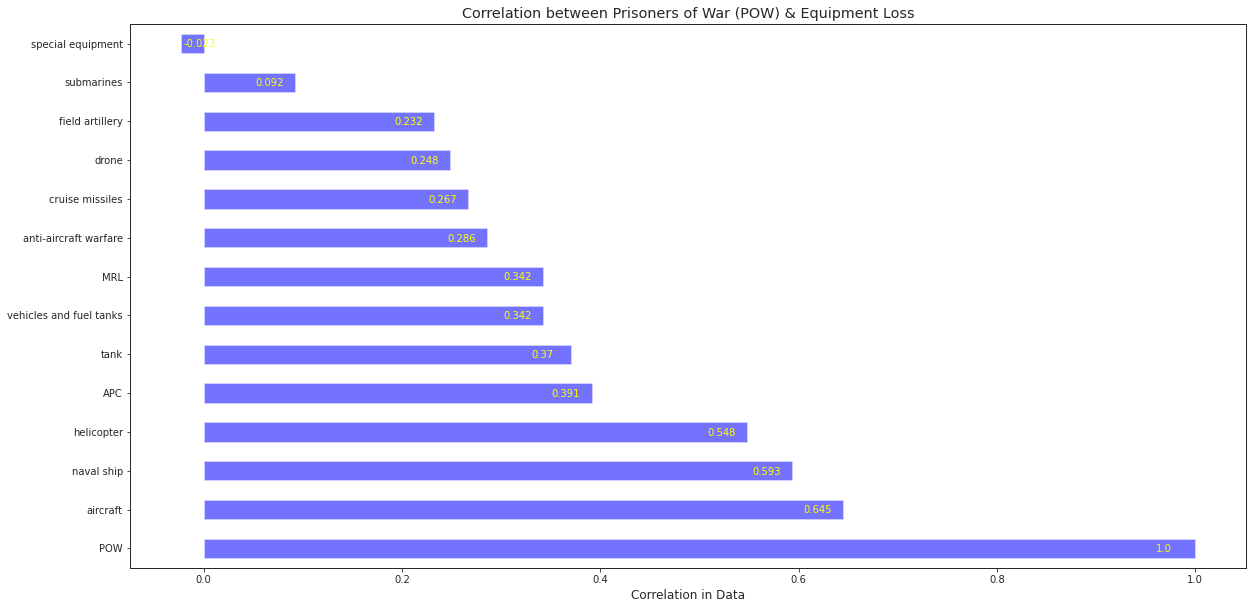

In [22]:
sns.set_style('ticks')

merge = pd.merge(russian_equipment, russian_personnel).drop(['day'], axis=1)
merged = merge.corr()['POW'].sort_values(ascending=False)

merged.plot.barh(title='Correlation between Prisoners of War (POW) & Equipment Loss',
                 figsize=(20,10), alpha=.55, color='blue')
for index, value in enumerate(merged):
    value = round(value, 3)
    label = format(value)
    if value>0:
        value-=.04
    else:
        value+=.003
    plt.annotate(label, xy=(value, index-.1), color='yellow', alpha=1)
plt.xlabel('Correlation in Data')
plt.show()

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> 4. Summary of Findings</b></p>
</div>

## Problem 10
##### What inferences can you make from the relationship between POW and Equipment loss?

In [23]:
merged.describe()

count    14.000000
mean      0.380941
std       0.253910
min      -0.023373
25%       0.252664
50%       0.342146
75%       0.508543
max       1.000000
Name: POW, dtype: float64

In [24]:
m = merged.describe()
k = merged.keys()
v = merged.values
rank = total_loss.set_index([pd.Index(range(1, len(total_loss) +1))])[total_loss.index.str.startswith(k[1])].index[0]
sd=round(m[2], 3)
s=''
if sd>1:
    s='high, and indicates that the there is much variability in the data; all points seem to be far from the mean or average correlation.'
else:
    s='low, and indicates that the there is not much variability in the data; all points seem to be close to the mean or average correlation.'

    
print(
 f"\t There is an overall strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. From \
the above data, it is evident that as the POW increases so does the overall equipment loss. The strength in correlation, ranges \
from {round(v[1], 3)} ({k[1]}) to {round(v[-1], 3)} ({k[-1]}). It should be noted that the strongest correlation exists \
not between the equipmet type with the highest loss({total_loss.index[-1]}) but with the type that ranked as having the \
{rank}th highest loss of all {len(total_loss.index)} equipment types assessed. The median correlation is {round(m[-3], 3)}; \
falling between {k[6]} and {k[7]}. The standard deviation is {sd} which is {s}  \n\n\t \
It is then valid to conclude that as the invasion continues, and POW increases so will {k[1]}s lost by at least \
{round(m[1], 3)} when compared to Prisoners Of War.\n\t\t #PeaceForUkraine"
    )

	 There is an overall strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. From the above data, it is evident that as the POW increases so does the overall equipment loss. The strength in correlation, ranges from 0.645 (aircraft) to -0.023 (special equipment). It should be noted that the strongest correlation exists not between the equipmet type with the highest loss(vehicles and fuel tanks) but with the type that ranked as having the 4th highest loss of all 13 equipment types assessed. The median correlation is 0.342; falling between vehicles and fuel tanks and MRL. The standard deviation is 0.254 which is low, and indicates that the there is not much variability in the data; all points seem to be close to the mean or average correlation.  

	 It is then valid to conclude that as the invasion continues, and POW increases so will aircrafts lost by at least 0.381 when compared to Prisoners Of War.
		 #PeaceForUkraine


<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>- Thank you</b></p>
</div>
